The objective of this notebook is to play with BOW and Multinomial Naive Bayes as our baseline model to have a reference in our experimentation


## Datasets

In [ ]:
import pandas as pd
from mlflow.models import infer_signature
import warnings
warnings.filterwarnings('ignore')


train = pd.read_csv("../../data/gold/train.csv")
test = pd.read_csv("../../data/gold/test.csv")
val = pd.read_csv("../../data/gold/validation.csv")




,features,target
0,hey next sun number there basic yoga course bu...,0
1,dhoni luck win big titleso winemoji,0
2,really hows master,0
3,see cup coffee animation,0
4,pain couldnt come worse time,0
...,...,...
4118,well boy glad g wasted night applebees nothing,0
4119,want number get laid tonight want real dogging...,1
4120,thanx lot,0
4121,well ball time make call,0


In [49]:
spam_rows = train[train['target'] == 1].value_counts().sum()
print(f"The SPAM rows of our dataset for modelling is: {spam_rows}")
ham_rows = train[train['target'] == 0].value_counts().sum()
print(f"The HAM rows of our dataset for modelling is: {ham_rows}")

print(f"The total rows of our dataset for modelling is: {len(train)}")
rows_to_create = ham_rows - spam_rows
print(f"We have to create {rows_to_create} rows to balance the dataset")

The SPAM rows of our dataset for modelling is: 517
The HAM rows of our dataset for modelling is: 3606
The total rows of our dataset for modelling is: 4123
We have to create 3089 rows to balance the dataset


## Augmentation 


The strategy is to repeat the rows until a condition (having 3606 lines) is met. Then take those rows and apply transformations.

In [50]:
train_list = train['features'].to_list()
complete_list = []

while len(complete_list) < rows_to_create:
    for row in train_list:
        if len(complete_list) < rows_to_create:
            complete_list.append(row)
        else:
            break


df_complete = pd.DataFrame(complete_list, columns=['features'])
df_complete['target'] = 1
print(df_complete.head())
    

                                            features  target
0  hey next sun number there basic yoga course bu...       1
1                dhoni luck win big titleso winemoji       1
2                                 really hows master       1
3                           see cup coffee animation       1
4                       pain couldnt come worse time       1


## Synonims Replacement

In [51]:
from nltk.corpus import wordnet as wn
import random
random.seed(1)

Let's find synonims for the 50% of the words

In [52]:
def replace_with_synonyms(text, replacement_prob=0.5):

    words = text.split()  
    new_words = []

    for word in words:
        if random.random() < replacement_prob:  
            synsets = wn.synsets(word)  
            if synsets:
                synonym = synsets[0].lemmas()[0].name()
                if synonym.lower() != word.lower():  
                    new_words.append(synonym)
                    continue
        
        new_words.append(word)  
    
    return ' '.join(new_words)


In [53]:
df_complete['features'] = df_complete['features'].apply(replace_with_synonyms)
df_complete

,features,target
0,hey next sun number there basic yoga course bu...,1
1,dhoni fortune win big titleso winemoji,1
2,truly hows maestro,1
3,see cup coffee animation,1
4,pain couldnt semen worse time,1
...,...,...
3084,hi darlin im way london smash another driver l...,1
3085,lol make plan new year,1
3086,well make luv ya,1
3087,number free numberst week nonumber nokia tone ...,1


In [55]:
combined_df = pd.concat([train, df_complete])
print(f"Lenght of the new dataframe is: {len(combined_df)}")

sum_target_0 = combined_df[combined_df['target'] == 0].value_counts().sum()
sum_target_1 = combined_df[combined_df['target'] == 1].value_counts().sum()
print(f"Total row sum for target = 0: {sum_target_0}")
print(f"Total row sum for target = 1: {sum_target_1}")

Lenght of the new dataframe is: 7212
Total row sum for target = 0: 3606
Total row sum for target = 1: 3606


In [58]:
X_train = combined_df['features']
y_train = combined_df['target']
X_test = test['features']
y_test = test['target']
signature = infer_signature(X_train, y_train)
X_train

0       hey next sun number there basic yoga course bu...
1                     dhoni luck win big titleso winemoji
2                                      really hows master
3                                see cup coffee animation
4                            pain couldnt come worse time
                              ...                        
3084    hi darlin im way london smash another driver l...
3085                               lol make plan new year
3086                                     well make luv ya
3087    number free numberst week nonumber nokia tone ...
3088    crazy argon he married like soman looking guy ...
Name: features, Length: 7212, dtype: object

## Pipeline

In [59]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    fbeta_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    auc,
    balanced_accuracy_score,
)


pipeline = Pipeline([
        ('vectorizer', CountVectorizer(ngram_range=(1, 1), max_features=None)),
        ('classifier', MultinomialNB())
    ])
    
pipeline.fit(X_train, y_train)
y_test_pred = pipeline.predict(X_test)


In [60]:
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {test_accuracy:.2f} ")

Accuracy: 0.89 


Notes: 

Now that the dataset is balanced the accuracy can be taken into consideration. Nice value :)

In [61]:
balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

Balanced Accuracy: 0.93


Notes: 

The model is correctly identifying both spam and non-spam messages with a high level of recall.

In [62]:
# F0.5-Score
f0_5_score = fbeta_score(y_test, y_test_pred, beta=0.5)
print(f"F0.5-Score: {f0_5_score:.2f}")

F0.5-Score: 0.58


In [63]:
report = classification_report(y_test, y_test_pred)
print("Classification Report (Test Data):")
print(report)

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       1.00      0.87      0.93       453
           1       0.52      0.98      0.68        63

    accuracy                           0.89       516
   macro avg       0.76      0.93      0.81       516
weighted avg       0.94      0.89      0.90       516



Notes:

- f0.5-score: not that important since we have our dataset balanced now.
- Precision: went down to 52% of the predicted positives are true positives.
- Recall: 98% of the real positives are true positives.
- F1-score: the model is doing a decent job on the label 0 but not on the label 1.

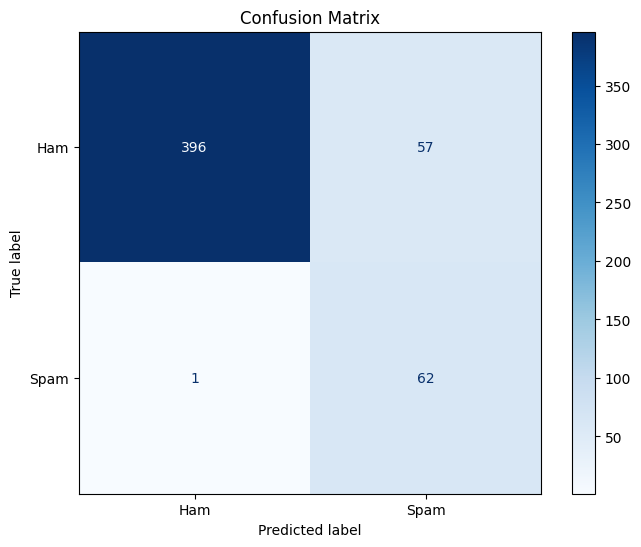

In [64]:
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
matrix_fig, ax = plt.subplots(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=['Ham', 'Spam'])
cm_display.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix")
plt.show()

Notes:

The confusion matrix looks very good.
- 57 e-mails were predicted as SPAM but they were HAM. (these are the ones I will try to minimize)
- 1 e-mail1 was predicted as HAM but it was SPAM.

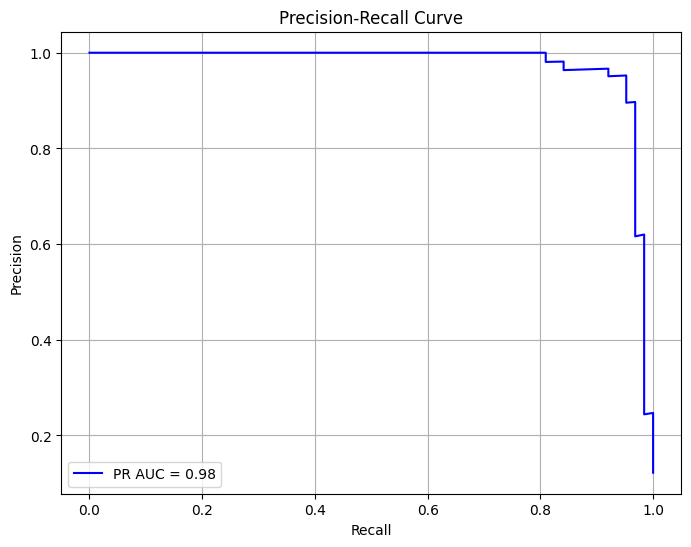

In [65]:
y_test_pred_prob = pipeline.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_test_pred_prob)
pr_auc = auc(recall, precision)

pr_fig, ax = plt.subplots(figsize=(8, 6))  
ax.plot(recall, precision, color='b', label=f'PR AUC = {pr_auc:.2f}')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')
ax.legend(loc="best")
ax.grid(True)
plt.show()


Notes: 

The area under the curve is 0.98 so the model strikes a strong balance between precision and recall across thresholds. The model identifies spam effectively without producing excessive false positives.

In [67]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

ROC AUC Score: 0.99


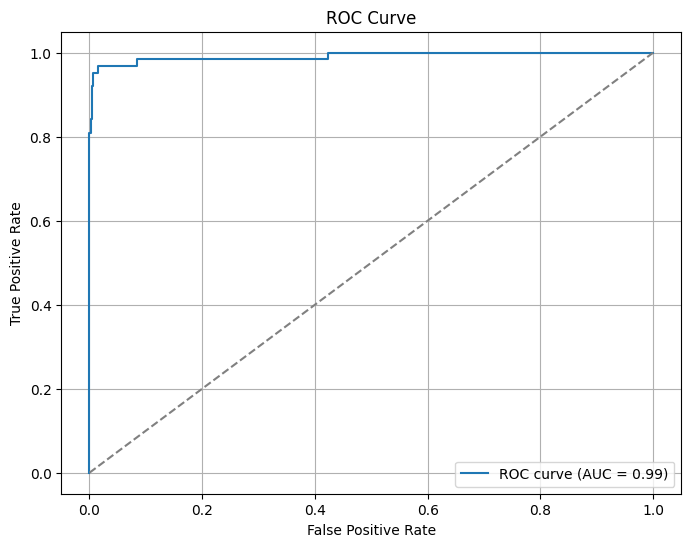

In [ ]:
roc_auc_train = roc_auc_score(y_train, y_train_pred)

roc_auc_test = roc_auc_score(y_test, y_test_pred_prob)

print(f"ROC AUC en entrenamiento: {roc_auc_train:.2f}")
print(f"ROC AUC en prueba: {roc_auc_test:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Notes: 

## MLFlow configuration

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

## MLFlow config


In [ ]:
from experiments_utils import experiment_status
import mlflow

import os
mlflow.set_tracking_uri("http://127.0.0.1:5000")
experiment_status()

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts
# mlflow.search_experiments()

# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
experiment_name, _, _ = experiment_status()
mlflow.set_experiment(experiment_name)

## MlFlow tracking

In [ ]:
   
with mlflow.start_run(run_name="baseline-model", log_system_metrics=True) as run:
    
    # Tags
    mlflow.set_tag("dataset", "Spam detection")
    mlflow.set_tag("task", "classification")
    mlflow.set_tag("vectorizer", "CountVectorizer")
    mlflow.set_tag("algorithm", "Multinomial Naive Bayes")
    mlflow.set_tag("framework", "Scikit-learn")
    mlflow.set_tag("language", "Python")
    mlflow.set_tag("environment", "Local")
    mlflow.set_tag("dataset_version", "1.0.0")
    mlflow.set_tag("preprocessing_version", "1.0.0")
    mlflow.set_tag("model_version", "0.0.1")
    mlflow.set_tag("developer", "Mldu")
    mlflow.set_tag("project_stage", "testing")

    #Datasets
    mlflow.log_input(mlflow.data.from_pandas(train, name="train dataset", targets="target"))
    mlflow.log_input(mlflow.data.from_pandas(test, name="test dataset", targets="target"))
    mlflow.log_input(mlflow.data.from_pandas(val, name="validation dataset", targets="target"))
    mlflow.log_artifact("../../data/gold/train.csv")
    mlflow.log_artifact("../../data/gold/test.csv")
    mlflow.log_artifact("../../data/gold/validation.csv")

    
    #BOW and model
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("model_type", "MultinomialNB")
    
    # Metrics
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("balanced_accuracy", balanced_accuracy)
    mlflow.log_metric("f0_5_score", f0_5_score)
    cr = classification_report(y_test, y_test_pred, output_dict=True)
    mlflow.log_metric("accuracy", cr.pop("accuracy"))
    for class_or_avg, metrics_dict in cr.items():
        for metric, value in metrics_dict.items():
            mlflow.log_metric(class_or_avg + '_' + metric,value)
    
    # Figures
    mlflow.log_figure(matrix_fig, "confusion-matrix.png")
    mlflow.log_figure(pr_fig, "precision-recall-curve.png")
    
    # CountVectorizer and MNB
    mlflow.sklearn.log_model(pipeline, "pipeline",signature=signature)
    
    # Notebook's name as tag and save as artifact
    notebook_name = os.path.basename(globals()['__vsc_ipynb_file__'])   
    mlflow.set_tag("source_notebook", f"{notebook_name}")
    mlflow.log_artifact(f"{notebook_name}", artifact_path="notebooks")


    print(f"Pipeline logged to MLflow under run ID {run.info.run_id}")

Conclusions:

- Clear overfitting 
- The model is not predicting at random since the accuracy is higher than the imbalance